In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('path/to/dir')

Mounted at /content/drive


# Lab3 - Machine Learning
## Multiclass Classification


Most of the times we encounter problems that are not binary. E.x. imagine you're given a photo and your task is to predict if it contains one of the following categories:
    - dog,
    - cat
    - horse
    - duck
    - etc etc
Given $K$ classes, you would like to assign $1$ class per data point.

<h2> Multi-class classification for Logistic Regression </h2>

- Given $K$ classes a straightforward way is to train $K$ binary classifiers.
    - One - Versus all
    - One class belongs to the positive category, the rest belongs to the negative category
- Then given a new data point $x$, we predict that the data point $x$ belongs to the class $i=\{1,2,...,k\}$ based on which classifier outputted the highest probability.

![title](img/onevsall.png)

<h2> Multi-class classification with Neural Networks </h2>

At Neural Networks we "force" the output of the $K$ units to be a discrete probability distribution over $K$ classes.


A probability distribution is valid if and only if the values of the output units:

1) must be non-negative

2) must sum to 1



$z \in \mathcal{R}^{Kx1}:$ the feature vector of the neural network(final output).

We can convert $z$ to probabilities with the softmax function

$$softmax(z) = \frac{ e^{z} }{ \sum_{i=1}^{k} e^{ z_{i} } } = \{  \frac{ e^{z_1} }{ \sum_{i=1}^{k} e^{ z_{i} } }, \frac{ e^{z_2} }{ \sum_{i=1}^{k} e^{ z_{i} } }, \dots, \frac{ e^{z_K} }{ \sum_{i=1}^{k} e^{ z_{i} } } \} $$

- Each unit is exponetiated
- exp is always positive
- The we normalize each unit to 0-1

<h2> One hot vectors </h2>

A binary vector of length K, where each value is 0 except for the class it belongs, the value is 1.

$t_{nk} \in \{ 0,1 \}, \sum_{k=1}^{K} t_{nk} = 1$

Example of k=3 classes

\begin{equation}
\begin{bmatrix}
    1\\
    0\\
    0
\end{bmatrix},
\begin{bmatrix}
    0\\
    1\\
    0
\end{bmatrix},
\begin{bmatrix}
    0\\
    0\\
    1
\end{bmatrix}
\end{equation}

### Model

Likelihood
$$p( T | W ) = \prod_{n=1}^{N} \prod_{k=1}^{K} y_{nk}^{t_{nk}}$$

The cost function (logLikelihood plus reguralization term) we want to maximize for the problem of classifying N number of data in K categories/classes is:

$$
E(W) = \sum_{n=1}^N \sum_{k=1}^K t_{nk} \log y_{nk}   -  \frac{\lambda}{2} \sum_{k=1}^K ||\mathbf{w_k}||^2,
$$

where $y_{nk}$ is the softmax function defined as:

$$y_{nk} = \frac{e^{\mathbf{w}_k^T \mathbf{x}_n}}{\sum_{j=1}^K e^{\mathbf{w}_j^T \mathbf{x}_n}}$$
$W$ is a $K \times (D+1)$ matrix where each line represents the vector $\mathbf{w}_k$.


The cost function can be simplified in the following form:



$$
E(W) = \sum_{n=1}^N \left[ \left( \sum_{k=1}^K t_{nk} \mathbf{w}_k^T \mathbf{x}_n \right) - \log \left( \sum_{j=1}^K e^{\mathbf{w}_j^T \mathbf{x}_n} \right) \right]   -  \frac{\lambda}{2} \sum_{k=1}^K ||\mathbf{w}_k||^2,
$$



In the above formula we have used the fact that $\sum_{k=1}^K t_{nk} = 1$.

The partial derrivatives of this function are given by the following $K \times (D+1)$ matrix:

$$
(T - S)^Τ X - \lambda W,
$$

where $T$ is an $N \times K$ matrix with the truth values of the training data, such that $[T]_{nk} = t_{nk}$, $S$ is the corresponding $N \times K$ matrix that holds the softmax probabilities such that $[S]_{nk} = y_{nk}$ and $X$ is the $N \times (D + 1)$ matrix of the input data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<h2> Softmax </h2>

In [ ]:
#use by default ax=1, when the array is 2D
#use ax=0 when the array is 1D
def softmax( x, ax=1 ):
    m = np.max( x, axis=ax, keepdims=True )#max per row
    #m = np.zeros_like(x)
    p = np.exp( x - m )
    return ( p / np.sum(p,axis=ax,keepdims=True) )

2D case

In [ ]:
z = np.array( [ [10,20,30,40], [20,50,45,45], [983,39,57,752], [574,575,597,525] ] )

In [ ]:
z

array([[ 10,  20,  30,  40],
       [ 20,  50,  45,  45],
       [983,  39,  57, 752],
       [574, 575, 597, 525]])

In [ ]:
pd.DataFrame( softmax( z ) )

,0,1,2,3
0,9.357198e-14,2.061060e-09,0.000045,9.999546e-01
1,9.233197e-14,9.867033e-01,0.006648,6.648354e-03
2,1.000000e+00,0.000000e+00,0.000000,4.764032e-101
3,1.026188e-10,2.789468e-10,1.000000,5.380186e-32


1D case

Let's take an example where all values are equal. As expected everything is 1 / |z|.

In [ ]:
z = np.full( (1,4), 1000)
softmax(z)

array([[0.25, 0.25, 0.25, 0.25]])

<h2> Mnist Dataset </h2>

In the data folder there is the dataset of mnist. Mnists consists of $28x28$ grayscale images. In total there are 10 training files
train0.txt, train1.txt, ..., train9.txt where each rows of train$k$.txt corresponds to an example that belongs to the class $k$.

The testing data follows the same format.

In total we have $6*10^5$ training examples and $10^3$ testing examples

In [ ]:
def load_data():
    """
    Load the MNIST dataset. Reads the training and testing files and create matrices.
    :Expected return:
    train_data:the matrix with the training data
    test_data: the matrix with the data that will be used for testing
    y_train: the matrix consisting of one
                        hot vectors on each row(ground truth for training)
    y_test: the matrix consisting of one
                        hot vectors on each row(ground truth for testing)
    """

    #load the train files
    df = None

    y_train = []

    for i in range( 10 ):
        tmp = pd.read_csv( 'data/mnist/train%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector
        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]

        for j in range( tmp.shape[0] ):
            y_train.append( hot_vector )
        #concatenate dataframes by rows
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    train_data = df.to_numpy()
    y_train = np.array( y_train )

    #load test files
    df = None

    y_test = []

    for i in range( 10 ):
        tmp = pd.read_csv( 'data/mnist/test%d.txt' % i, header=None, sep=" " )
        #build labels - one hot vector

        hot_vector = [ 1 if j == i else 0 for j in range(0,10) ]

        for j in range( tmp.shape[0] ):
            y_test.append( hot_vector )
        #concatenate dataframes by rows
        if i == 0:
            df = tmp
        else:
            df = pd.concat( [df, tmp] )

    test_data = df.to_numpy()
    y_test = np.array( y_test )

    return train_data, test_data, y_train, y_test

Load the dataset

In [ ]:
X_train, X_test, y_train, y_test = load_data()
X_train.shape, y_train.shape

((60000, 784), (60000, 10))

<h2> View of the dataset </h2>

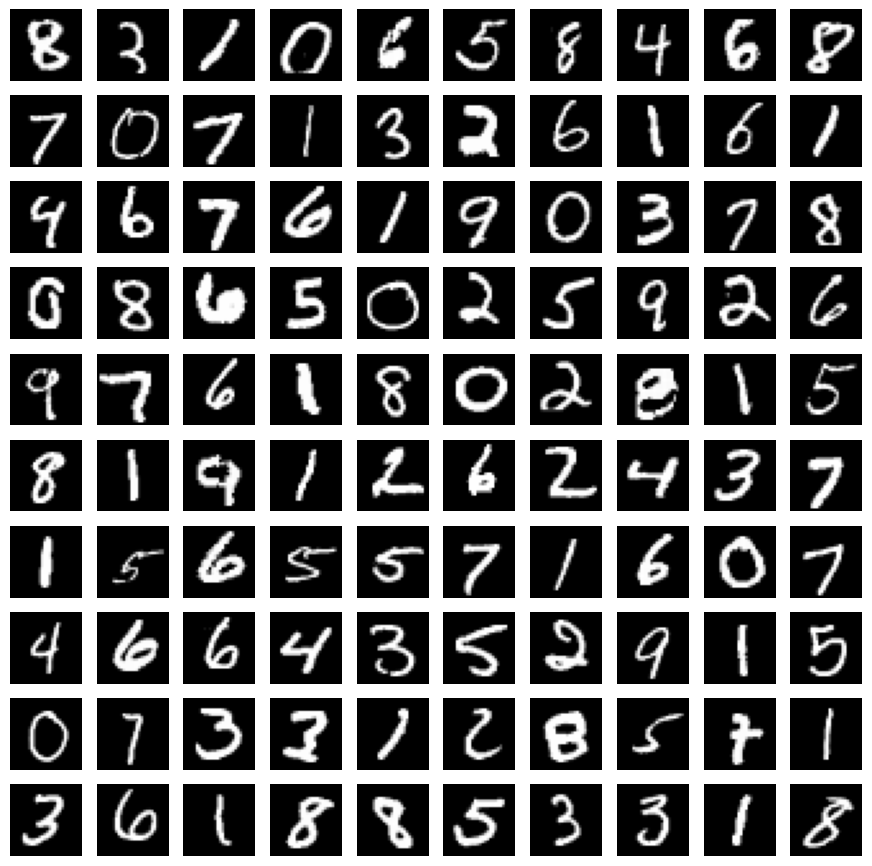

In [ ]:
# plot 5 random images from the training set
n = 100
sqrt_n = int( n**0.5 )
samples = np.random.randint(X_train.shape[0], size=n)

plt.figure( figsize=(11,11) )

cnt = 0
for i in samples:
    cnt += 1
    #plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_train[i].reshape(28,28), cmap='gray'  )

plt.show()

<h2> Normalize the dataset </h2>

In [ ]:
X_train = X_train.astype(float)/255
X_test = X_test.astype(float)/255

Add column of ones to the dataset

In [ ]:
X_train = np.hstack( (np.ones((X_train.shape[0],1) ), X_train) )
X_test = np.hstack( (np.ones((X_test.shape[0],1) ), X_test) )

For the cost function

$$E(w)=\sum_{n=1}^N \sum_{k=1}^K t_{nk} \log( y_{nk} )-  \frac{\lambda}{2} ||\mathbf{w}||^2,
$$

$$
E(w) = \sum_{n=1}^N \left[ \left( \sum_{k=1}^K t_{nk} \mathbf{w}_k^T \mathbf{x}_n \right) - \log \left( \sum_{j=1}^K e^{\mathbf{w}_j^T \mathbf{x}_n} \right) \right]   -  \frac{\lambda}{2} ||\mathbf{w}||^2,
$$

$$ \frac{ \partial E(w) }{ \partial w } = (T-Y)^{T} X - \lambda w$$


we can also use the logsumexp trick, where m is the maximum element for numerical stability
\begin{align}
\log \sum_{i=1}^{n} e^{\mathbf{w}_j^T \mathbf{x}_n} &= \log \Bigr( \sum_{i=1}^{n} e^{\mathbf{w}_j^T \mathbf{x}_n +m -m}\Bigl) \\
&= \log \Bigr( \sum_{i=1}^{n} e^m e^{\mathbf{w}_j^T \mathbf{x}_n-m} ) \Bigl) \\
&= \log \Bigr( e^m \sum_{i=1}^{n} e^{\mathbf{w}_j^T \mathbf{x}_n-m} ) \Bigl) \\
&= \log \ e^m + \log \Bigr( \sum_{i=1}^{n} e^{\mathbf{w}_j^T \mathbf{x}_n-m} ) \Bigl) \\
&= m + \log \Bigr( \sum_{i=1} e^{\mathbf{w}_j^T \mathbf{x}_n-m}  \Bigl)
\end{align}

In [ ]:
N, D = X_train.shape
K = 10
Winit = 0.5 * np.ones((K, D))

In [ ]:
X_train.shape, Winit.shape

((60000, 785), (10, 785))

In [ ]:
def cost_grad_softmax(W, X, t, lamda):

    #X: NxD
    #W: KxD
    #t: NxK

    E = 0
    N, D = X.shape
    K = t.shape[1]

    y = softmax( np.dot(X,W.T) )

    for n in range(N):
        for k in range(K):
            E += -t[n][k] * np.log( y[n][k] )
    E += lamda * np.sum( np.square( W ) ) / 2

    gradEw = -np.dot( (t-y).T, X ) + lamda * W

    return E, gradEw

In [ ]:
cost_grad_softmax(Winit,X_train,y_train,0.125)

(138277.76182972503,
 array([[ 7.706250e+01,  6.250000e-02,  6.250000e-02, ...,  6.250000e-02,
          6.250000e-02,  6.250000e-02],
        [-7.419375e+02,  6.250000e-02,  6.250000e-02, ...,  6.250000e-02,
          6.250000e-02,  6.250000e-02],
        [ 4.206250e+01,  6.250000e-02,  6.250000e-02, ...,  6.250000e-02,
          6.250000e-02,  6.250000e-02],
        ...,
        [-2.649375e+02,  6.250000e-02,  6.250000e-02, ...,  6.250000e-02,
          6.250000e-02,  6.250000e-02],
        [ 1.490625e+02,  6.250000e-02,  6.250000e-02, ...,  6.250000e-02,
          6.250000e-02,  6.250000e-02],
        [ 5.106250e+01,  6.250000e-02,  6.250000e-02, ...,  6.250000e-02,
          6.250000e-02,  6.250000e-02]]))

In [ ]:
def ml_softmax_train(t, X, lamda, Winit, options):
    """inputs :
      t: N x K output data vector indicating the classes
      X: N x (D+1) input data vector with ones already added in the first column
      lamda: the positive regularizarion parameter
      winit: D+1 dimensional vector of the initial values of the parameters
      options: options(1) is the maximum number of iterations
               options(2) is the tolerance
               options(3) is the learning rate eta
    outputs :
      w: the trained D+1 dimensional vector of the parameters"""

    W = Winit

    # Maximum number of iteration of gradient ascend
    _iter = options[0]

    # Tolerance
    tol = options[1]

    # Learning rate
    eta = options[2]

    Ewold = np.inf
    costs = []
    for i in range( 1, _iter+1 ):
        Ew, gradEw = cost_grad_softmax(W, X, t, lamda)
        # save cost
        costs.append(Ew)
        # Show the current cost function on screen
        if i % 50 == 0:
            print('Iteration : %d, Cost function :%f' % (i, Ew))

        # Break if you achieve the desired accuracy in the cost function
        if np.abs(Ew - Ewold) < tol:
            break

        # Update parameters based on gradient ascend
        W = W - eta * gradEw

        Ewold = Ew

    return W, costs

### Gradient checking


During gradient ascent/descent we compute the gradients $\frac{\partial E}{\partial w}$, where $w$ denotes the parameters of the model.

In order to make sure that these gradients are correct we will compare the exact gradients(that we have coded) with numerical estimates obtained by finite differences, you can use your code for computing $E$ to verify the code for computing $\frac{\partial E}{\partial w}$.
    Let's look back at the definition of a derivative (or gradient):
    
$$ \frac{\partial E}{\partial w} = \lim_{\varepsilon \to 0} \frac{E(w + \varepsilon) - E(w - \varepsilon)}{2 \varepsilon} \tag{1}$$  

We know the following:
- $\frac{\partial E}{\partial w}$ is what you want to make sure you're computing correctly. ,
- You can compute $E(w + \varepsilon)$ and $E(w - \varepsilon)$ (in the case that $w$ is a real number), since you're confident your implementation for $E$ is correct.

Let's use equation (1) and a small value ( around $10^-4$ or $10^-6$, much smaller values could lead to numerical issues )for $\varepsilon$ to make sure that your code for computing  $\frac{\partial E}{\partial w}$ is correct!

![title](img/grad.png)

In [ ]:
def gradcheck_softmax(Winit, X, t, lamda):

    W = np.random.rand(*Winit.shape)
    epsilon = 1e-6

    _list = np.random.randint(X.shape[0], size=5)
    x_sample = np.array(X[_list, :])
    t_sample = np.array(t[_list, :])

    Ew, gradEw = cost_grad_softmax(W, x_sample, t_sample, lamda)

    print( "gradEw shape: ", gradEw.shape )

    numericalGrad = np.zeros(gradEw.shape)
    # Compute all numerical gradient estimates and store them in
    # the matrix numericalGrad
    for k in range(numericalGrad.shape[0]):
        for d in range(numericalGrad.shape[1]):

            #add epsilon to the w[k,d]
            w_tmp = np.copy(W)
            w_tmp[k, d] += epsilon
            e_plus, _ = cost_grad_softmax(w_tmp, x_sample, t_sample, lamda)

            #subtract epsilon to the w[k,d]
            w_tmp = np.copy(W)
            w_tmp[k, d] -= epsilon
            e_minus, _ = cost_grad_softmax( w_tmp, x_sample, t_sample, lamda)

            #approximate gradient ( E[ w[k,d] + theta ] - E[ w[k,d] - theta ] ) / 2*e
            numericalGrad[k, d] = (e_plus - e_minus) / (2 * epsilon)

    return ( gradEw, numericalGrad )


In [ ]:
N, D = X_train.shape

K = 10#num of classes

# initialize w for the gradient ascent
Winit = np.zeros((K, D))

# regularization parameter
lamda = 0.1

# options for gradient descent
options = [500, 1e-6, 0.5/N]# Maximum number of iteration of gradient ascend, Tolerance, Learning rate

gradEw, numericalGrad = gradcheck_softmax(Winit, X_train, y_train, lamda)

# Absolute norm
print( "The difference estimate for gradient of w is : ", np.max(np.abs(gradEw - numericalGrad)) )

gradEw shape:  (10, 785)
The difference estimate for gradient of w is :  2.726137271480411e-08


Let's view the first rows of the gradient and of the gradient checking

#### The gradient values

In [ ]:
pd.DataFrame( gradEw ).head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0.084689,0.010671,0.014140,0.003423,0.051205,0.000098,0.087598,0.039294,0.078926,0.053491,...,0.051536,0.088275,0.061120,0.012034,0.014203,0.072277,0.020239,0.050088,0.039427,0.048573
1,0.018619,0.014263,0.035719,0.049860,0.017596,0.027957,0.055652,0.001933,0.072187,0.061708,...,0.000831,0.082939,0.072290,0.002233,0.033461,0.068141,0.041897,0.071229,0.024837,0.078957
2,2.677965,0.099076,0.000156,0.085671,0.020819,0.047057,0.097598,0.018324,0.002476,0.019000,...,0.001124,0.074732,0.088684,0.072129,0.011852,0.058733,0.085602,0.017261,0.071499,0.009190
3,-1.881255,0.049898,0.086275,0.013945,0.024061,0.000684,0.056531,0.063908,0.066066,0.082628,...,0.021721,0.023341,0.021600,0.032874,0.018201,0.025658,0.029709,0.030606,0.090626,0.001700
4,2.130880,0.032423,0.079267,0.072320,0.056511,0.034253,0.000040,0.019630,0.059268,0.050540,...,0.070339,0.004667,0.048957,0.062946,0.077064,0.038438,0.034641,0.039006,0.086223,0.096733


#### The approximations of the gradient

In [ ]:
pd.DataFrame( numericalGrad ).head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,0.084689,0.010671,0.014140,0.003423,0.051205,0.000098,0.087598,0.039294,0.078926,0.053491,...,0.051536,0.088275,0.061120,0.012034,0.014203,0.072277,0.020239,0.050088,0.039427,0.048573
1,0.018619,0.014263,0.035719,0.049860,0.017596,0.027957,0.055652,0.001933,0.072187,0.061708,...,0.000831,0.082939,0.072290,0.002233,0.033461,0.068141,0.041897,0.071229,0.024837,0.078957
2,2.677965,0.099076,0.000156,0.085671,0.020819,0.047057,0.097598,0.018324,0.002476,0.019000,...,0.001124,0.074732,0.088684,0.072129,0.011852,0.058733,0.085602,0.017261,0.071499,0.009190
3,-1.881255,0.049898,0.086275,0.013945,0.024061,0.000684,0.056531,0.063908,0.066066,0.082628,...,0.021721,0.023341,0.021600,0.032874,0.018201,0.025658,0.029709,0.030606,0.090626,0.001700
4,2.130880,0.032423,0.079267,0.072320,0.056511,0.034253,0.000040,0.019630,0.059268,0.050540,...,0.070339,0.004667,0.048957,0.062946,0.077064,0.038438,0.034641,0.039006,0.086223,0.096733


<h2> Training </h2>

In [ ]:
# N of X
N, D = X_train.shape

K = 10

# initialize w for the gradient ascent
Winit = np.zeros((K, D))

# regularization parameter
lamda = 0.1

# options for gradient descent
options = [500, 1e-6, 0.5/N]

#gradcheck_softmax(Winit, X_train, y_train, lamda)

# Train the model
W, costs = ml_softmax_train(y_train, X_train, lamda, Winit, options)

Iteration : 50, Cost function :27693.134663
Iteration : 100, Cost function :23608.500011
Iteration : 150, Cost function :21863.261809
Iteration : 200, Cost function :20829.742304
Iteration : 250, Cost function :20123.574690
Iteration : 300, Cost function :19600.363809
Iteration : 350, Cost function :19191.903447
Iteration : 400, Cost function :18861.130281
Iteration : 450, Cost function :18585.891532
Iteration : 500, Cost function :18352.000544


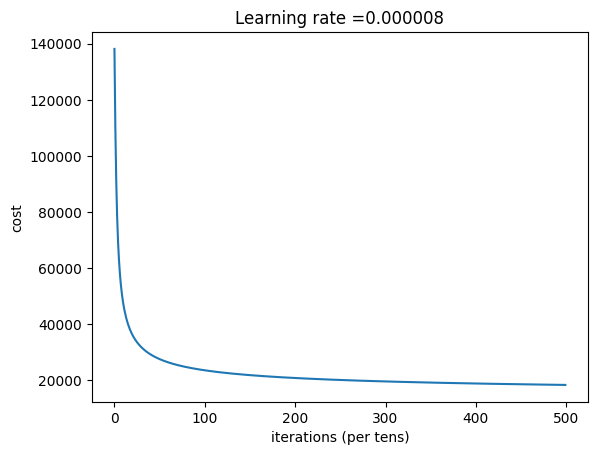

In [ ]:
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per tens)')
plt.title("Learning rate =" + str(format(options[2], 'f')))
plt.show()

<h2> Predict </h2>

In [ ]:
def ml_softmax_test(W, X_test):
    ytest = softmax( X_test.dot(W.T) )
    # Hard classification decisions
    ttest = np.argmax(ytest, 1)
    return ttest

In [ ]:
pred = ml_softmax_test(W, X_test)

<h2> Accuracy </h2>

In [ ]:
np.mean( pred == np.argmax(y_test,1) )

0.9183

Now lets take a look at our test data. Check out some of the misclassified test data.

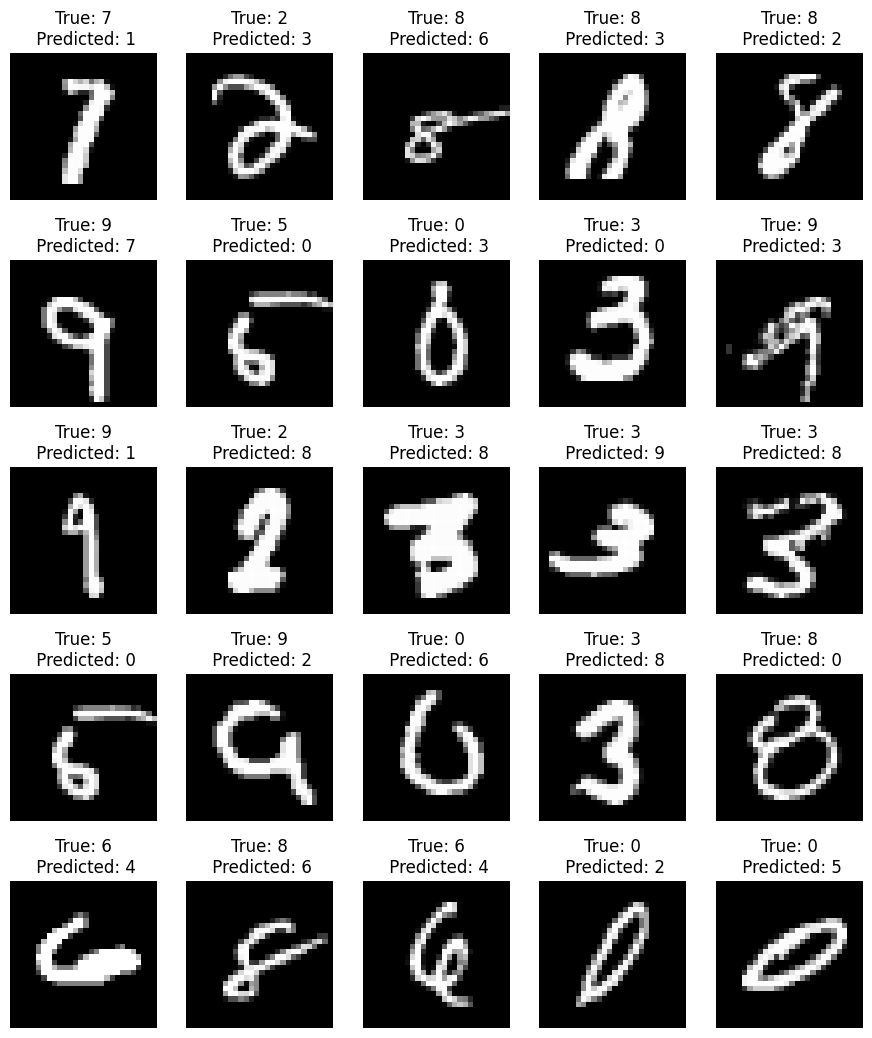

In [ ]:
faults = np.where(np.not_equal(np.argmax(y_test,1),pred))[0]
# plot n misclassified examples from the Test set
n = 25
samples = np.random.choice(faults, n)
sqrt_n = int( n ** 0.5 )

plt.figure( figsize=(11,13) )

cnt = 0
for i in samples:
    cnt += 1
    #plt.subplot( sqrt_n, sqrt_n, cnt )
    plt.subplot( sqrt_n, sqrt_n, cnt ).axis('off')
    plt.imshow( X_test[i,1:].reshape(28,28)*255, cmap='gray' )
    plt.title("True: "+str(np.argmax(y_test,1)[i])+ "\n Predicted: "+ str(pred[i]))

plt.show()

What is in the <strong>W</strong> weight array?

In [ ]:
W.shape


(10, 785)

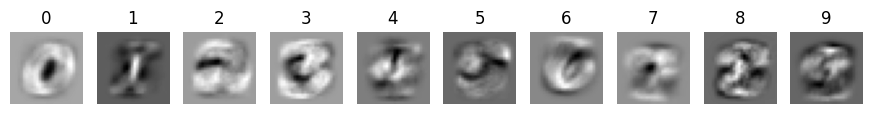

In [ ]:
plt.figure( figsize=(11,13) )
cnt = 0
for i in np.delete( W, 0, axis=1 ):
    cnt+=1
    plt.subplot( 1, 10, cnt ).axis('off')
    plt.title( cnt-1 )
    plt.imshow( i.reshape( (28,28) ).reshape(28,28)*255, cmap='gray' )
plt.show()

### Keras - Tensorflow (optional)

tf.keras is TensorFlow's high-level API for building and training deep learning models.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *

/home/sotirisnik/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The needed version of running this experiment was tensorflow 1.13.1

In [ ]:
tf.__version__

'1.13.1'

First let's remove the columns of 1 we had inserted in our data

In [ ]:
X_train.shape, y_train.shape

((60000, 785), (60000, 10))

axis=1 refers that it will delete columns, meanwhile axis=0 would refer to rows

In [ ]:
np.delete( X_train, 0, axis=1 ).shape#delete first column

(60000, 784)

In [ ]:
X_train = np.delete( X_train, 0, axis=1 )

In [ ]:
X_test = np.delete( X_test, 0, axis=1 )

Next we just check image format on how to prepare our data. It could be either

(img_rows,img_cols,img_channels)
or
(img_channels,img_rows,img_cols)mn

In our case the channel will go to the last column.

In [ ]:
print( tf.keras.backend.image_data_format() )
img_rows, img_cols = 28, 28

#channels = number of colors
if tf.keras.backend.image_data_format() == 'channels_last':
    X_train = X_train.reshape( (-1,img_rows,img_cols,1) )
    X_test = X_test.reshape( (-1,img_rows,img_cols,1) )
    input_shape = ( img_rows, img_cols, 1 )
else:
    X_train = X_train.reshape( (-1,1,img_rows,img_cols) )
    X_test = X_test.reshape( (-1,1,img_rows,img_cols) )
    input_shape = ( 1, img_rows, img_cols )
num_classes = 10
print( input_shape )

channels_last
(28, 28, 1)


In [ ]:
X_train.shape, y_train.shape

((60000, 28, 28, 1), (60000, 10))

### Setting up our model

In [ ]:
batch_size = 128

In [ ]:
model = tf.keras.Sequential()
model.add( Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add( Conv2D(64, (3, 3), activation='relu') )
model.add( MaxPooling2D(pool_size=(2, 2)) )
model.add( Conv2D(64, (3, 3), activation='relu') )
model.add( MaxPooling2D(pool_size=(2, 2)) )

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile( loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'] )

Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
model_log = model.fit( X_train, y_train, validation_data=(X_test,y_test), epochs=10)

Train on 60000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
60000/60000 [==============================] - 21s 358us/sample - loss: 0.1106 - acc: 0.9651 - val_loss: 0.0499 - val_acc: 0.9828
Epoch 2/10
60000/60000 [==============================] - 19s 308us/sample - loss: 0.0390 - acc: 0.9884 - val_loss: 0.0293 - val_acc: 0.9905
Epoch 3/10
60000/60000 [==============================] - 18s 306us/sample - loss: 0.0262 - acc: 0.9920 - val_loss: 0.0257 - val_acc: 0.9918
Epoch 4/10
60000/60000 [==============================] - 19s 310us/sample - loss: 0.0192 - acc: 0.9943 - val_loss: 0.0303 - val_acc: 0.9904
Epoch 5/10
60000/60000 [==============================] - 18s 302us/sample - loss: 0.0158 - acc: 0.9950 - val_loss: 0.0312 - val_acc: 0.9904
Epoch 6/10
60000/60000 [==============================] - 18s 302us/sample - loss: 0.0109 - acc: 0.9965 - val_loss: 0.0415 - val_acc: 0.9898
Epoch 7/10
60000/60000 [==============================] 

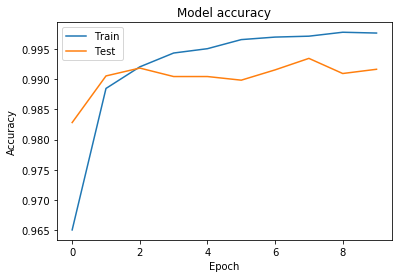

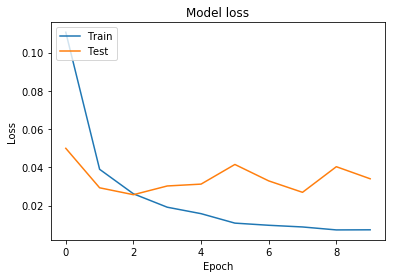

In [ ]:
# Plot training & validation accuracy values
plt.plot( model_log.history['acc'])
plt.plot( model_log.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(model_log.history['loss'])
plt.plot( model_log.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### View Activations of Convolutional layers

First we gather all the layers's output and we construct a model that given an input, it will return all of the activations back.

In [ ]:
layer_outputs = [ layer.output for layer in model.layers ]
activation_model = tf.keras.Model( inputs=model.input, outputs=layer_outputs )

In [ ]:
layer_names = [ layer.name for layer in model.layers ]

In [ ]:
img = X_train[0].reshape( (-1,28,28,1) )

The image we will feed into the network will be

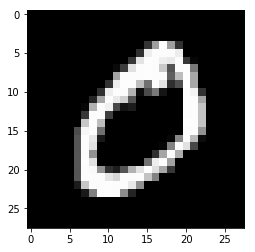

In [ ]:
plt.imshow( img.reshape((28,28)), cmap='gray' )

So let's get the activations values

In [ ]:
activations = activation_model.predict(img)

Think of the shapes in the form of (1,img_rows,img_cols,num_filters), so what is left to do, is to iterate through all num_filters and plot the

img_rows $\times$ img_cols images.

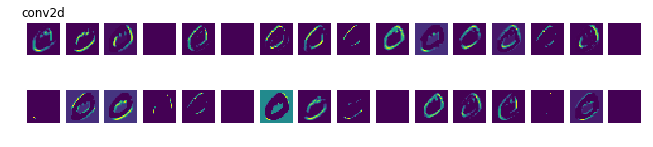

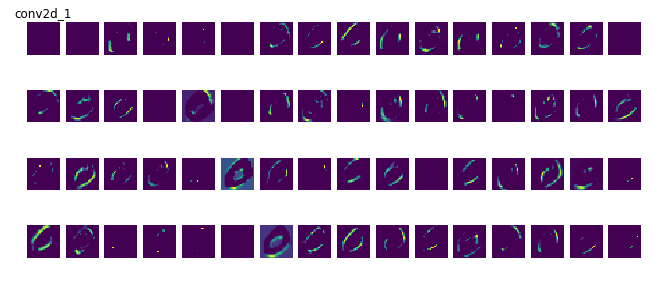

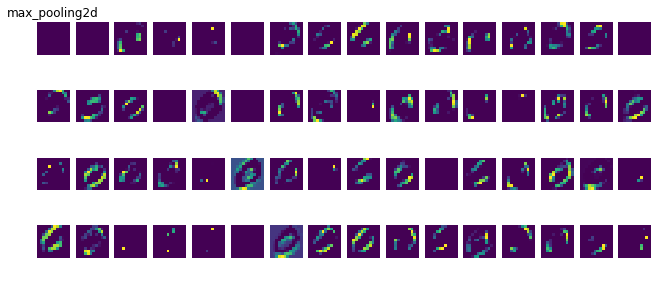

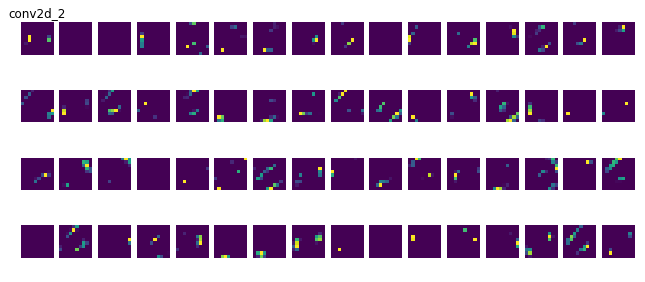

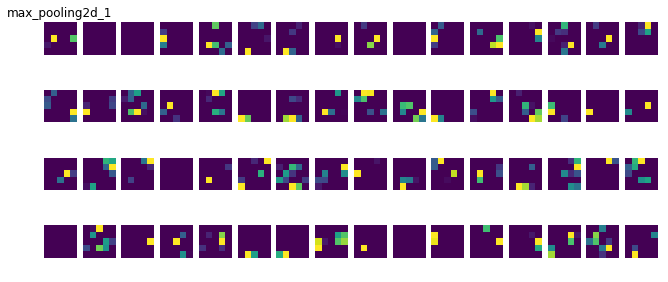

In [ ]:
for i, lname in zip( activations, layer_names ):
    if len(i.shape) == 4:
        fig = plt.figure( figsize=(11,11) )
        ax = fig.add_subplot(9,16,1)
        ax.title.set_text( lname )
        num = i.shape[-1]
        for k in range( num ):
            tmp = i[:,:,:,k]
            tmp = tmp.reshape( (tmp.shape[1], tmp.shape[2]) )
            ax = fig.add_subplot(9,16,k+1)
            ax.axis('off')
            ax.imshow( tmp )
plt.show()

More about CNNs : https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53